AUC: 0.9943533742801602
Accuracy: 0.9664739991120737
Recall: 0.958386511737251
F1: 0.9628782277349869
Precision: 0.9674422990541132


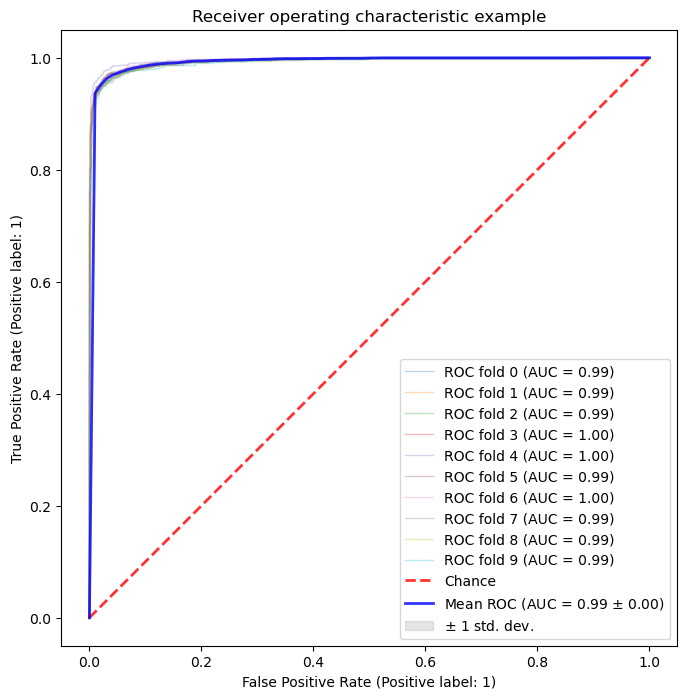

In [3]:
import xgboost
from sklearn import metrics
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import auc, RocCurveDisplay
import numpy as np


# preparing database
data = pd.read_csv('/media/zzh/data/AMP/xgboost_classifier/data/top14Featured_all.csv')
X = data.iloc[:, 2:-1].values
Y = data.iloc[:, -1].values


# setting parameters
lr = 0.1
md = 5
ne = 2000

# define the model
model = xgboost.XGBClassifier(max_depth=md, n_estimators=ne, learning_rate=lr, objective="binary:logistic", tree_method="hist", use_label_encoder=False, eval_metric='logloss', device="cuda")

# use kfold to verify model parameters
kfold = KFold(n_splits=10, random_state=7, shuffle=True)

# calculated metrics
auc_scores = cross_val_score(model, X, Y, cv=kfold, scoring='roc_auc')
print(f'AUC: {auc_scores.mean()}')
accuracy_scores = cross_val_score(model, X, Y, cv=kfold, scoring='accuracy')
print(f'Accuracy: {accuracy_scores.mean()}')
recall_scores = cross_val_score(model, X, Y, cv=kfold, scoring='recall')
print(f'Recall: {recall_scores.mean()}')
f1_scores = cross_val_score(model, X, Y, cv=kfold, scoring='f1')
print(f'F1: {f1_scores.mean()}')
precision_scores = cross_val_score(model, X, Y, cv=kfold, scoring='precision')
print(f'Precision: {precision_scores.mean()}')

# Run the classifier using cross-validation and plot the ROC curve
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(8, 8))
for i, (train, test) in enumerate(kfold.split(X, Y)):
    model.fit(X[train], Y[train])
    viz = RocCurveDisplay.from_estimator(model, X[test], Y[test],
                                         name='ROC fold {}'.format(i),
                                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()

#### 对模型特征权重参数进行提取

In [ ]:
# Extract model feature parameters
f_i= model.feature_importances_
f_i= pd.DataFrame({'feature_importances':f_i})

#### 单个roc-auc曲线绘制

In [ ]:
y_pred_proba = model.predict_proba(x_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred_proba[:,1], pos_label=1)
roc_auc = metrics.auc(fpr,tpr)

plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.savefig('auc_roc.pdf')
plt.show()